In [1]:
import pandas as pd
import json
import re
import numpy as np

from sklearn.externals import joblib
import pickle

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
pd.set_option('display.max_columns', 150)

## Process Cultivate data for prediction

In [3]:
#cultivate_sentences.p was created in notebook 06-clustering
sentences = pickle.load(open('cultivate_sentences.p', 'rb'))
sentences.head()

,sent_index,sentiment,thread_id,timestamp,sender_id,concrete,request_prob,polite_prob,question,msg_id,team_id,inform,conventional,request_action,request_info,msg_size,adv,articles,aux_verbs,convo_index,convo_size,imp_prons,female_recipients,female_prons,male_recipients,male_prons,subordinates,superiors,unique_tokens,gender_unknown,power_unknown,parent_predict,parent_prob,per_prons,preps,quants,response_time,sender_gender,sub_conjs
0,3,1,0,2001-10-05 02:38:26,0,3.980000,0.154175,0.447116,False,723973,0,0.269913,0.122803,0.005557,0.006111,3,0,0,0,0,1,0,0,0,5,0,0,0,21,6,11,0,NaN,0,0,0,NaN,I,0
1,2,2,0,2001-10-05 02:38:26,0,4.465000,0.229237,0.433185,False,723973,0,0.102239,0.345797,0.004580,0.009907,3,0,0,0,0,1,0,0,0,5,0,0,0,2,6,11,0,NaN,0,0,0,NaN,I,0
2,1,2,0,2001-10-05 02:38:26,0,2.160000,0.148573,0.399924,False,723973,0,0.309767,0.073297,0.006243,0.005516,3,0,0,0,0,1,0,0,0,5,0,0,0,4,6,11,0,NaN,0,0,0,NaN,I,0
3,0,1,0,2001-10-05 02:38:26,0,3.296667,0.047411,0.389760,False,723973,0,0.357122,0.000236,0.006312,0.002823,3,0,0,0,0,1,0,0,0,5,0,0,0,15,6,11,0,NaN,0,0,0,NaN,I,0
4,3,1,0,2001-10-06 07:38:26,0,3.980000,0.154175,0.447116,False,724694,0,0.269913,0.122803,0.005557,0.006111,3,0,0,0,0,1,0,0,0,5,0,0,0,21,6,11,0,NaN,0,0,0,NaN,I,0


In [4]:
sender_gender = {
    'I':0,
    'M':1,
    'F':2
}

#w['female'] = w['female'].map({'female': 1, 'male': 0})
sentences['sender_gender'] = sentences['sender_gender'].map(sender_gender)

In [5]:
groupby = sentences.groupby('msg_id')
avgs = groupby.mean()
stds = groupby.std()
sums = groupby.sum()
avgs.head()

,sent_index,sentiment,concrete,request_prob,polite_prob,question,inform,conventional,request_action,request_info,msg_size,adv,articles,aux_verbs,convo_index,convo_size,imp_prons,female_recipients,female_prons,male_recipients,male_prons,subordinates,superiors,unique_tokens,gender_unknown,power_unknown,parent_prob,per_prons,preps,quants,sender_gender,sub_conjs
msg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,1.5,1.500000,2.602371,0.383466,0.517987,0.0,0.501998,0.004534,0.010361,0.009096,3.0,0.500000,0.250000,0.750000,0.0,1.0,0.0,0.0,0.0,5.0,0.000000,0.0,0.0,15.000000,7.0,12.0,NaN,2.500000,1.500000,0.250000,0.0,0.250000
5,2.5,1.333333,3.134820,0.308676,0.515260,0.0,0.363733,0.244143,0.008651,0.010642,5.0,0.166667,0.500000,0.166667,0.0,1.0,0.0,0.0,0.0,5.0,0.166667,0.0,0.0,11.500000,6.0,11.0,NaN,0.666667,1.500000,0.500000,0.0,0.166667
6,4.0,1.555556,2.397724,0.175903,0.531130,0.0,0.615570,0.003230,0.004679,0.004471,8.0,0.666667,1.666667,0.444444,0.0,1.0,0.0,0.0,0.0,5.0,0.000000,0.0,0.0,16.555556,6.0,11.0,NaN,0.222222,1.555556,0.555556,0.0,0.222222
37,2.5,1.333333,2.514151,0.230190,0.492014,0.0,0.585759,0.002017,0.022334,0.003986,5.0,0.666667,2.000000,0.166667,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,16.833333,2.0,2.0,NaN,0.333333,1.500000,1.500000,0.0,0.500000
39,11.0,1.347826,2.384991,0.270916,0.539568,0.0,0.609613,0.001993,0.002383,0.013909,22.0,0.434783,1.391304,0.826087,0.0,1.0,0.0,0.0,0.0,5.0,0.000000,0.0,0.0,20.217391,10.0,15.0,NaN,1.782609,2.086957,1.043478,0.0,0.347826


In [6]:
sums.sample(5)

,sent_index,sentiment,concrete,request_prob,polite_prob,question,inform,conventional,request_action,request_info,msg_size,adv,articles,aux_verbs,convo_index,convo_size,imp_prons,female_recipients,female_prons,male_recipients,male_prons,subordinates,superiors,unique_tokens,gender_unknown,power_unknown,parent_prob,per_prons,preps,quants,sender_gender,sub_conjs
msg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
56216,6,6,10.831981,0.713180,1.736842,0.0,2.294035,0.007965,0.010925,0.008475,12,1,2,1,0,4,0,0,0,8,4,4,8,56,12,8,NaN,4,5,6,0,0
1302936,28,11,21.114487,0.984548,2.703574,0.0,4.036350,0.833899,0.042343,0.054108,56,1,9,4,0,8,0,0,0,16,0,0,8,136,24,32,NaN,2,15,7,16,1
3358,1,3,5.877391,0.216682,0.396981,0.0,0.631789,0.009369,0.006199,0.012869,2,0,0,0,0,2,0,0,0,4,0,0,0,234,2,6,NaN,0,7,9,0,0
176644,1,3,7.732500,0.468286,0.454698,0.0,0.333381,0.441889,0.013669,0.015451,2,0,0,0,0,2,0,6,0,16,0,0,0,9,66,88,NaN,0,2,1,0,0
780433,3,5,7.233511,1.094826,1.576411,0.0,2.163556,0.003115,0.012243,0.020210,6,5,2,4,0,9,0,0,0,3,0,0,0,55,6,9,NaN,7,2,1,3,3


In [7]:
y = avgs['sentiment']
per_message_cols = ['convo_size', 'female_recipients', 'male_recipients',
                   'subordinates', 'superiors', 'gender_unknown', 'power_unknown', 'sender_gender']
per_message_info = avgs.filter(items = per_message_cols)

In [8]:
avg_std_cols = ['concrete', 'request_prob', 'polite_prob', 'inform', 'conventional',
               'request_action', 'request_info']

avgs = avgs.filter(items = avg_std_cols)
stds = stds.filter(items = avg_std_cols)

In [9]:
avgs.columns = [str(col) + '_mean' for col in avgs.columns]
stds.columns = [str(col) + '_std' for col in stds.columns]

In [10]:
#some std are null because only one value,
#others because means are missing
#first fill all nulls with 0, then replace with NaN based on empty means
stds = stds.fillna(0)

In [11]:
drop_from_sums = ['sent_index', 'sentiment', 'convo_index', 'convo_size', 'parent_prob']

sums.drop(avg_std_cols + drop_from_sums + per_message_cols, axis = 1, inplace = True)

In [12]:
for_prediction = pd.concat([avgs, stds, per_message_info, sums], axis = 1)
for_prediction.head()

,concrete_mean,request_prob_mean,polite_prob_mean,inform_mean,conventional_mean,request_action_mean,request_info_mean,concrete_std,request_prob_std,polite_prob_std,inform_std,conventional_std,request_action_std,request_info_std,convo_size,female_recipients,male_recipients,subordinates,superiors,gender_unknown,power_unknown,sender_gender,question,msg_size,adv,articles,aux_verbs,imp_prons,female_prons,male_prons,unique_tokens,per_prons,preps,quants,sub_conjs
msg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,2.602371,0.383466,0.517987,0.501998,0.004534,0.010361,0.009096,0.202054,0.415612,0.172268,0.169645,0.004842,0.010482,0.007872,1.0,0.0,5.0,0.0,0.0,7.0,12.0,0.0,0.0,12,2,1,3,0,0,0,60,10,6,1,1
5,3.134820,0.308676,0.515260,0.363733,0.244143,0.008651,0.010642,1.007306,0.221159,0.062783,0.226657,0.389217,0.013225,0.004289,1.0,0.0,5.0,0.0,0.0,6.0,11.0,0.0,0.0,30,1,3,1,0,0,1,69,4,9,3,1
6,2.397724,0.175903,0.531130,0.615570,0.003230,0.004679,0.004471,0.174529,0.172909,0.139823,0.094904,0.004941,0.003222,0.004099,1.0,0.0,5.0,0.0,0.0,6.0,11.0,0.0,0.0,72,6,15,4,0,0,0,149,2,14,5,2
37,2.514151,0.230190,0.492014,0.585759,0.002017,0.022334,0.003986,0.712547,0.248282,0.070037,0.139121,0.002879,0.047338,0.001387,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,30,4,12,1,0,0,0,101,2,9,9,3
39,2.384991,0.270916,0.539568,0.609613,0.001993,0.002383,0.013909,0.196451,0.201417,0.110420,0.192553,0.003073,0.001969,0.039334,1.0,0.0,5.0,0.0,0.0,10.0,15.0,0.0,0.0,506,10,32,19,0,0,0,465,41,48,24,8


In [13]:
for_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71246 entries, 3 to 1367876
Data columns (total 35 columns):
concrete_mean          71246 non-null float64
request_prob_mean      71182 non-null float64
polite_prob_mean       69286 non-null float64
inform_mean            71246 non-null float64
conventional_mean      71246 non-null float64
request_action_mean    71246 non-null float64
request_info_mean      71246 non-null float64
concrete_std           71246 non-null float64
request_prob_std       71246 non-null float64
polite_prob_std        71246 non-null float64
inform_std             71246 non-null float64
conventional_std       71246 non-null float64
request_action_std     71246 non-null float64
request_info_std       71246 non-null float64
convo_size             71246 non-null float64
female_recipients      71246 non-null float64
male_recipients        71246 non-null float64
subordinates           71246 non-null float64
superiors              71246 non-null float64
gender_unknown 

In [14]:
def replace_std_col(col_name, df = for_prediction):
    list_of_means = df[col_name + '_mean'].tolist()
    list_of_stds = df[col_name + '_std'].tolist()
    new_means, new_stds = [], []
    
    for mean, std in zip(list_of_means, list_of_stds):
        new_means.append(mean)
        if np.isnan(mean):
            new_stds.append(np.nan)
        else:
            new_stds.append(std)
    
    df[col_name + '_mean'] = new_means
    df[col_name + '_std'] = new_stds
    return df

In [15]:
for_prediction = replace_std_col('polite_prob')
for_prediction = replace_std_col('request_prob')

In [16]:
for_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71246 entries, 3 to 1367876
Data columns (total 35 columns):
concrete_mean          71246 non-null float64
request_prob_mean      71182 non-null float64
polite_prob_mean       69286 non-null float64
inform_mean            71246 non-null float64
conventional_mean      71246 non-null float64
request_action_mean    71246 non-null float64
request_info_mean      71246 non-null float64
concrete_std           71246 non-null float64
request_prob_std       71182 non-null float64
polite_prob_std        69286 non-null float64
inform_std             71246 non-null float64
conventional_std       71246 non-null float64
request_action_std     71246 non-null float64
request_info_std       71246 non-null float64
convo_size             71246 non-null float64
female_recipients      71246 non-null float64
male_recipients        71246 non-null float64
subordinates           71246 non-null float64
superiors              71246 non-null float64
gender_unknown 

In [112]:
len(y) == len(for_prediction)

True

## Prediction on Cultivate's data

Predict the mean sentiment of each message given different stylistic features of the message, different predicted tones of the message and information about the sender/receiver.

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [113]:
y_matrix, X_matrix = y.as_matrix(), for_prediction.as_matrix()

In [114]:
imp = Imputer(missing_values = 'NaN', strategy = 'mean')
X_imp = imp.fit_transform(X_matrix)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_imp,
                                                   y_matrix,
                                                   test_size = 0.25,
                                                   random_state = 4)

In [116]:
rf = RandomForestRegressor(n_jobs = -1,
                          random_state = 2)
params = {
    'n_estimators':[500, 1000],
    'max_features':['auto', 'sqrt', 'log2']
}

grid = GridSearchCV(estimator = rf, param_grid = params, cv = 5)
grid = grid.fit(X_train, y_train)

In [118]:
grid.best_params_

{'max_features': 'sqrt', 'n_estimators': 1000}

In [119]:
rf = RandomForestRegressor(n_estimators = 1000,
                          max_features = 'sqrt',
                          n_jobs = -1,
                          random_state = 2)

%time rf.fit(X_train, y_train)

CPU times: user 3min 44s, sys: 3.52 s, total: 3min 48s
Wall time: 1min 7s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [243]:
joblib.dump(rf, 'rf_model.pkl')

['rf_model.pkl']

In [120]:
rf_pred = rf.predict(X_test)
print('The R squared value of the random forest model is {0:.3f}, implying ~{1:.1%} of the variance is expalined by our model.'\
      .format(r2_score(y_test, rf_pred), r2_score(y_test, rf_pred)))

The R squared value of the random forest model is 0.464, implying ~46.4% of the variance is expalined by our model.


## Evaluation and interpretation

In [136]:
import scikitplot.plotters as skplt

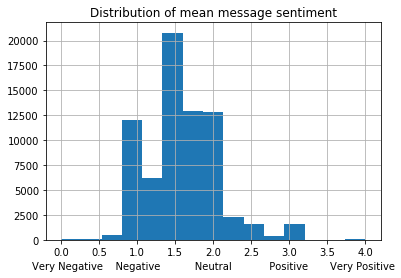

In [231]:
response_hist = y.hist(bins = 15);
_ = plt.title('Distribution of mean message sentiment')
_ = plt.xlabel('Very Negative    Negative           Neutral            Positive       Very Positive')
response_hist;

In [232]:
response_hist.figure.savefig('response_hist.png')

In [174]:
def label_sentiments(array, labels, cuts = [1, 2, 3, 4]):
    y = array.tolist()
    y_labels = []
    for i in range(len(y)):
        if y[i] < cuts[0]:
            y_labels.append(labels[0])
        elif y[i] >= cuts[0] and y[i] < cuts[1]:
            y_labels.append(labels[1])
        elif y[i] >= cuts[1] and y[i] < cuts[2]:
            y_labels.append(labels[2])
        elif y[i] >= cuts[2] and y[i] < cuts[3]:
            y_labels.append(labels[3])
        else:
            y_labels.append(labels[4])
    return y_labels

In [188]:
labels = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
y_true_sentiment = label_sentiments(y_test, labels)
y_pred_sentiment = label_sentiments(rf_pred, labels)

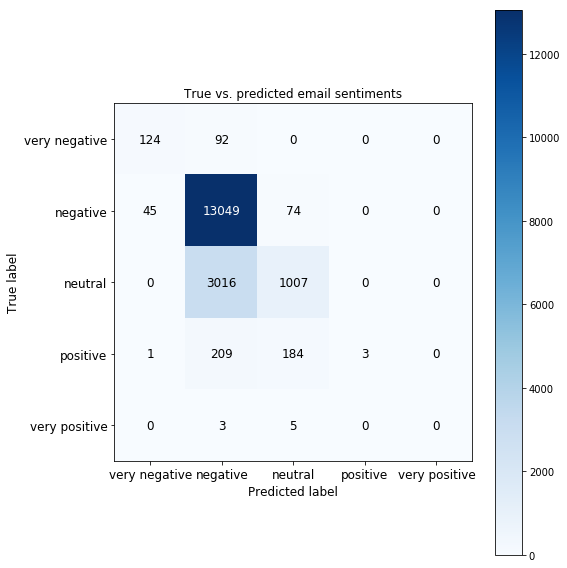

In [240]:
confusion_true_sentiments = skplt.plot_confusion_matrix(y_true = y_true_sentiment,
                                          y_pred = y_pred_sentiment,
                                          labels = labels,
                                          figsize = (8, 8), text_fontsize = 'large',
                                          title = 'True vs. predicted email sentiments')
plt.tight_layout()

In [241]:
confusion_true_sentiments.figure.savefig('confusion_true_sentiment_scores.png')

In [186]:
cuts = pd.qcut(y, 5, retbins = True)
cuts = cuts[1]
cuts[1:]

array([ 1.16923077,  1.5       ,  1.66666667,  2.        ,  4.        ])

In [193]:
label_cuts = ['very negative', 'negative-neutral', 'neutral', 'neutral-positive', 'positive']
y_true_cuts = label_sentiments(y_test, label_cuts, cuts[1:])
y_pred_cuts = label_sentiments(rf_pred, label_cuts, cuts[1:])

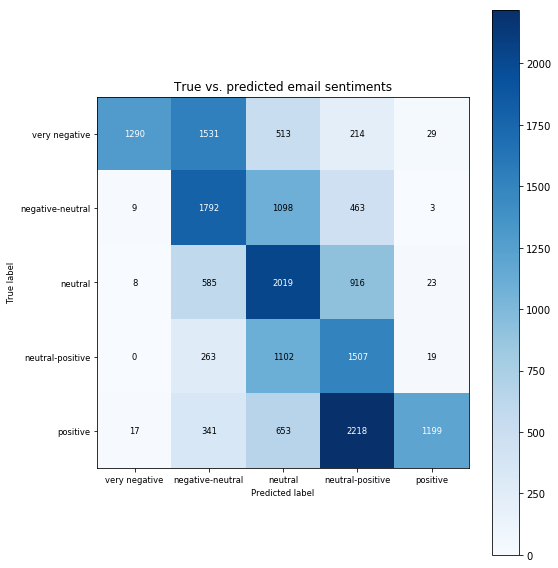

In [249]:
confusion_cuts = skplt.plot_confusion_matrix(y_true = y_true_cuts,
                                          y_pred = y_pred_cuts,
                                          labels = label_cuts,
                                          figsize = (8, 8), text_fontsize = 'small',
                                          title = 'True vs. predicted email sentiments')
_ = plt.tight_layout()

In [250]:
confusion_cuts.figure.savefig('confusion_cuts.png')

In [199]:
def find_important_features(df, clf, col1 = 'features', col2 = 'importance'):
    list_cols = df.columns.tolist()
    feature_importance = pd.DataFrame(list(zip(list_cols, clf.feature_importances_)), columns = [col1, col2])
    features = pd.DataFrame(columns = [col1, col2])
    
    for col in list_cols:
        row = feature_importance[feature_importance[col1] == col]
        features = features.append(row)
    features = features.sort_values(col2, ascending = False)
    
    return features

In [222]:
important_features = find_important_features(for_prediction, rf)
important_features.to_csv('important_features.csv', index = False)

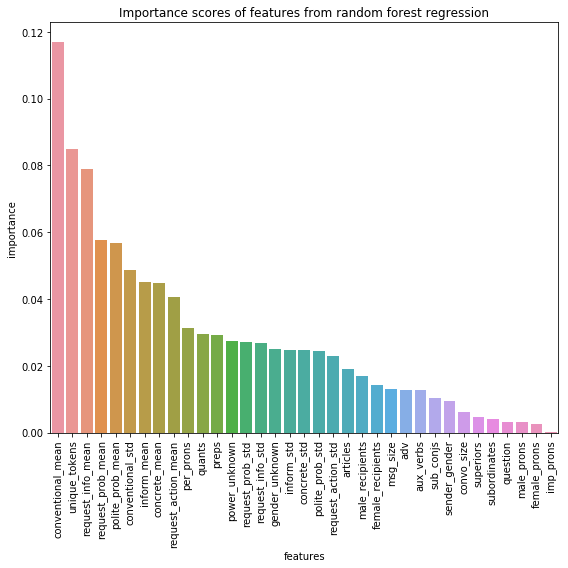

In [270]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8);
rf_features = sns.barplot('features', 'importance', data = important_features)
rf_features = plt.xticks(np.arange(important_features.shape[0]), 
                         important_features['features'], 
                         rotation = 'vertical')
rf_features = plt.title('Importance scores of features from random forest regression')
_ = plt.tight_layout()

In [271]:
rf_features.figure.savefig('rf_features.png')

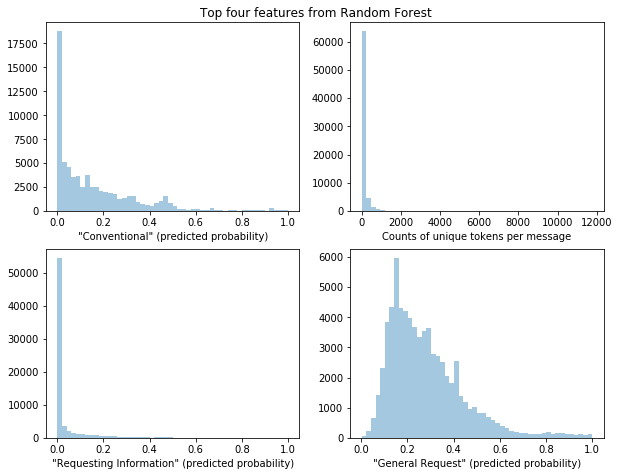

In [268]:
fig = plt.figure(1);
fig.set_size_inches(10, 7)

fig = plt.subplot(221);
fig = sns.distplot(for_prediction['conventional_mean'], 
                   kde = False)
#_ = plt.title('"Conventional" message')
_ = plt.xlabel('"Conventional" (predicted probability)')

fig = plt.subplot(222);
fig = sns.distplot(for_prediction['unique_tokens'], 
                   kde = False)
#_ = plt.title('Unique tokens')
_ = plt.xlabel('Counts of unique tokens per message')

fig = plt.subplot(223);
fig = sns.distplot(for_prediction['request_info_mean'].dropna(), 
                   kde = False)
#_ = plt.title('"Requesting Information"')
_ = plt.xlabel('"Requesting Information" (predicted probability)')

fig = plt.subplot(224);
fig = sns.distplot(for_prediction['request_prob_mean'].dropna(), 
                   kde = False)
#_ = plt.title('"General Request"')
_ = plt.xlabel('"General Request" (predicted probability)')

_ = plt.subplots_adjust(top=0.95)
_ = plt.suptitle('Top four features from Random Forest')
#_ = plt.tight_layout()

In [17]:
df_modeling = for_prediction.copy()
df_modeling['sentiment'] = y

In [19]:
df_modeling.head()

,concrete_mean,request_prob_mean,polite_prob_mean,inform_mean,conventional_mean,request_action_mean,request_info_mean,concrete_std,request_prob_std,polite_prob_std,inform_std,conventional_std,request_action_std,request_info_std,convo_size,female_recipients,male_recipients,subordinates,superiors,gender_unknown,power_unknown,sender_gender,question,msg_size,adv,articles,aux_verbs,imp_prons,female_prons,male_prons,unique_tokens,per_prons,preps,quants,sub_conjs,sentiment
msg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,2.602371,0.383466,0.517987,0.501998,0.004534,0.010361,0.009096,0.202054,0.415612,0.172268,0.169645,0.004842,0.010482,0.007872,1.0,0.0,5.0,0.0,0.0,7.0,12.0,0.0,0.0,12,2,1,3,0,0,0,60,10,6,1,1,1.500000
5,3.134820,0.308676,0.515260,0.363733,0.244143,0.008651,0.010642,1.007306,0.221159,0.062783,0.226657,0.389217,0.013225,0.004289,1.0,0.0,5.0,0.0,0.0,6.0,11.0,0.0,0.0,30,1,3,1,0,0,1,69,4,9,3,1,1.333333
6,2.397724,0.175903,0.531130,0.615570,0.003230,0.004679,0.004471,0.174529,0.172909,0.139823,0.094904,0.004941,0.003222,0.004099,1.0,0.0,5.0,0.0,0.0,6.0,11.0,0.0,0.0,72,6,15,4,0,0,0,149,2,14,5,2,1.555556
37,2.514151,0.230190,0.492014,0.585759,0.002017,0.022334,0.003986,0.712547,0.248282,0.070037,0.139121,0.002879,0.047338,0.001387,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,30,4,12,1,0,0,0,101,2,9,9,3,1.333333
39,2.384991,0.270916,0.539568,0.609613,0.001993,0.002383,0.013909,0.196451,0.201417,0.110420,0.192553,0.003073,0.001969,0.039334,1.0,0.0,5.0,0.0,0.0,10.0,15.0,0.0,0.0,506,10,32,19,0,0,0,465,41,48,24,8,1.347826


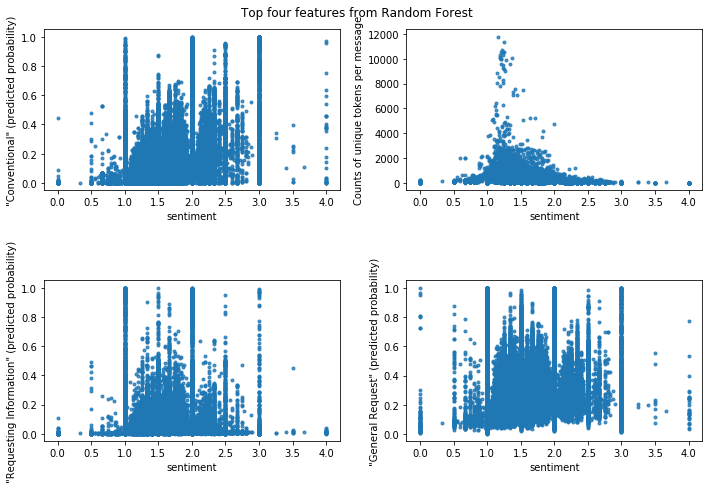

In [26]:
fig = plt.figure(1);
fig.set_size_inches(10, 7)

fig = plt.subplot(221);
_ = sns.regplot('sentiment', 'conventional_mean', data = df_modeling, 
                fit_reg = False, marker = '.')
#_ = plt.title('"Conventional" message')
_ = plt.ylabel('"Conventional" (predicted probability)')

fig = plt.subplot(222);
_ = sns.regplot('sentiment', 'unique_tokens', data = df_modeling, 
                fit_reg = False, marker = '.')
#_ = plt.title('Unique tokens')
_ = plt.ylabel('Counts of unique tokens per message')

fig = plt.subplot(223);
_ = sns.regplot('sentiment', 'request_info_mean', data = df_modeling, 
                fit_reg = False, marker = '.')
#_ = plt.title('"Requesting Information"')
_ = plt.ylabel('"Requesting Information" (predicted probability)')

fig = plt.subplot(224);
_ = sns.regplot('sentiment', 'request_prob_mean', data = df_modeling, 
                fit_reg = False, marker = '.')
#_ = plt.title('"General Request"')
_ = plt.ylabel('"General Request" (predicted probability)')

_ = plt.subplots_adjust(top=0.76)
_ = plt.suptitle('Top four features from Random Forest')
_ = plt.tight_layout()

In [27]:
fig.figure.savefig('feature_distribution.png')

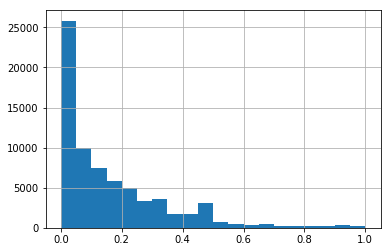

In [235]:
important_cols
for col in important_cols:
    for_prediction[col].hist(bins = 20);

In [273]:
for_prediction.to_csv('features_for_prediction.csv')

In [275]:
import lime
import lime.lime_tabular

In [323]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
                                                   feature_names = for_prediction.columns,
                                                   class_names = ['sentiment'],
                                                   verbose = True, mode = 'regression')

i = 40
exp = explainer.explain_instance(X_test[i], rf.predict, num_features = 10);
exp.show_in_notebook(show_table = True)
exp.as_list()

Intercept 1.70272101046
Prediction_local [ 1.49225506]
Right: 1.47907142857


[('conventional_mean <= 0.02', -0.1294411155504038),
 ('conventional_std <= 0.00', -0.045668759149024386),
 ('imp_prons <= 0.00', 0.039960371221076499),
 ('female_prons <= 0.00', -0.033288813671583747),
 ('0.01 < request_info_mean <= 0.02', 0.031681216435282898),
 ('0.45 < polite_prob_mean <= 0.50', -0.029155910840883901),
 ('request_prob_mean <= 0.16', -0.024095063651353457),
 ('msg_size <= 2.00', -0.021698232056318593),
 ('sub_conjs <= 0.00', 0.015612430310905014),
 ('male_prons <= 0.00', -0.014372076530523643)]

In [294]:
pickle.dump(X_train, open('/Users/yuwenwu/insight/flaskapp/webapp/X_train.p', 'wb'))

In [292]:
pickle.dump(X_test, open('/Users/yuwenwu/insight/flaskapp/webapp/X_test.p', 'wb'))